In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
dataset = pd.read_csv("Price_Agriculture_commodities_Week.csv")

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23093 entries, 0 to 23092
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         23093 non-null  object 
 1   District      23093 non-null  object 
 2   Market        23093 non-null  object 
 3   Commodity     23093 non-null  object 
 4   Variety       23093 non-null  object 
 5   Grade         23093 non-null  object 
 6   Arrival_Date  23093 non-null  object 
 7   Min Price     23093 non-null  float64
 8   Max Price     23093 non-null  float64
 9   Modal Price   23093 non-null  float64
dtypes: float64(3), object(7)
memory usage: 1.8+ MB


In [5]:
dataset.isna().sum()

State           0
District        0
Market          0
Commodity       0
Variety         0
Grade           0
Arrival_Date    0
Min Price       0
Max Price       0
Modal Price     0
dtype: int64

In [6]:
dataset.describe()

,Min Price,Max Price,Modal Price
count,23093.000000,23093.000000,23093.000000
mean,4187.077045,4976.034260,4602.917742
std,5472.783385,6277.308057,5843.822711
min,0.000000,0.000000,0.830000
25%,1750.000000,2000.000000,1955.000000
50%,2725.000000,3400.000000,3000.000000
75%,5000.000000,6000.000000,5500.000000
max,223500.000000,227500.000000,225500.000000


In [7]:
dataset["Commodity"].value_counts().head(10)

Commodity
Potato                   1205
Onion                    1134
Brinjal                  1033
Green Chilli              931
Bhindi(Ladies Finger)     860
Cucumbar(Kheera)          712
Bottle gourd              693
Tomato                    671
Banana                    669
Wheat                     639
Name: count, dtype: int64

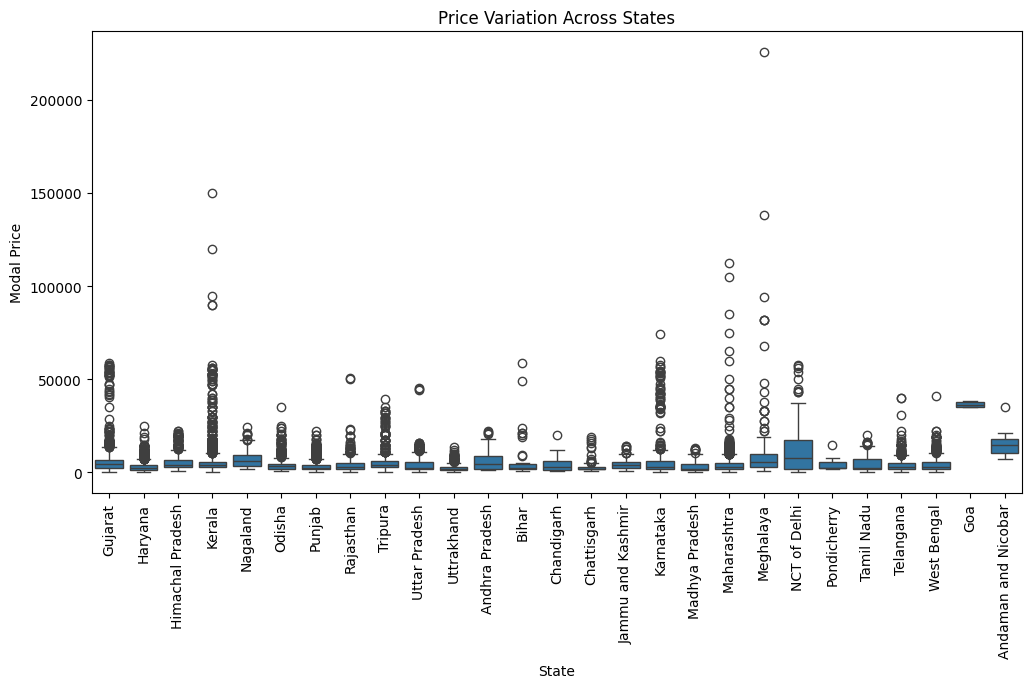

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='State', y='Modal Price', data=dataset)
plt.xticks(rotation=90)
plt.title("Price Variation Across States")
plt.show()

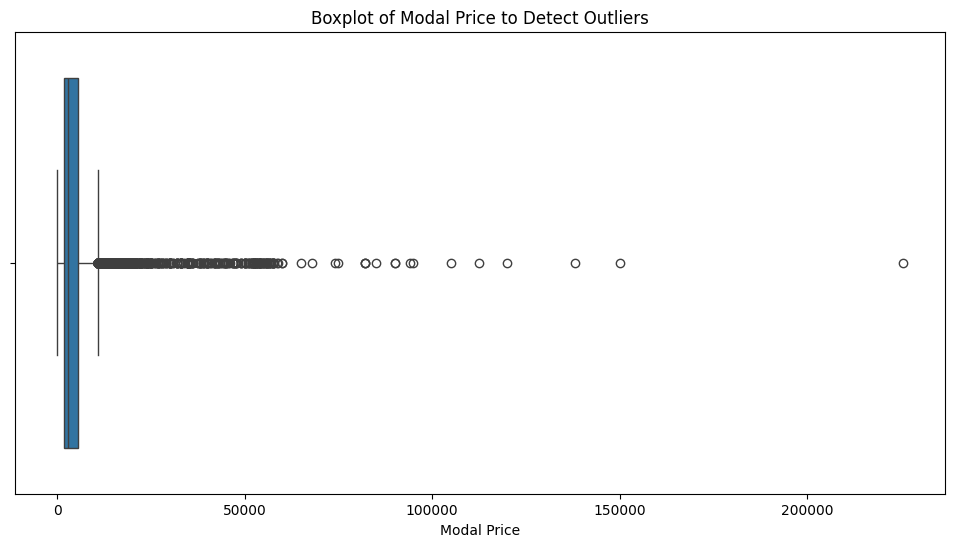

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=dataset['Modal Price'])
plt.title("Boxplot of Modal Price to Detect Outliers")
plt.show()

In [10]:
# Filter commodities that have at least 50 occurrences
commodity_counts = dataset["Commodity"].value_counts()
valid_commodities = commodity_counts[commodity_counts >= 50].index
dataset = dataset[dataset["Commodity"].isin(valid_commodities)]

# Print the number of commodities retained
print(f"Retained {len(valid_commodities)} commodities after filtering.")

Retained 82 commodities after filtering.


In [11]:
dataset.dropna(inplace=True)
dataset['Arrival_Date'] = pd.to_datetime(dataset['Arrival_Date'])

C:\Users\laxmi\AppData\Local\Temp\ipykernel_15016\983153863.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dataset['Arrival_Date'] = pd.to_datetime(dataset['Arrival_Date'])


In [12]:
categorical_cols = dataset.select_dtypes(include=['object']).columns

# Create a dictionary to store label encoders for future reference if needed (e.g., for test data)
label_encoders = {}

# Loop over each categorical column and apply LabelEncoder
for col in categorical_cols:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])
    label_encoders[col] = le

In [13]:
# Feature Engineering
dataset['Year'] = dataset['Arrival_Date'].dt.year
dataset['Month'] = dataset['Arrival_Date'].dt.month
dataset['DayOfWeek'] = dataset['Arrival_Date'].dt.dayofweek

In [14]:
# Remove Outliers using IQR Method
Q1 = dataset['Modal Price'].quantile(0.25)
Q3 = dataset['Modal Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

dataset = dataset[(dataset['Modal Price'] >= lower_bound) & (dataset['Modal Price'] <= upper_bound)]

# Print shape after outlier removal
print(f"Dataset shape after outlier removal: {dataset.shape}")


Dataset shape after outlier removal: (20381, 13)


In [15]:
# Define Features and Target
X = dataset.drop(columns=['Modal Price', 'Arrival_Date','Max Price', 'Min Price'])
y = dataset['Modal Price']

In [16]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
# Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
print("\nRandom Forest Results:")
print(f"  R² Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")


Random Forest Results:
  R² Score: 0.8592
  MAE: 510.86
  RMSE: 873.03


In [19]:
# Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
print("\nXGBoost Results:")
print(f"  R² Score: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")


XGBoost Results:
  R² Score: 0.8458
  MAE: 591.18
  RMSE: 913.77


In [20]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
# Define Hyperparameter Grid for Random Forest
rf_param_grid = {
    'n_estimators': randint(50, 300),  # Number of trees
    'max_depth': randint(5, 30),       # Depth of trees
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

# Randomized Search for Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=20,  # Limit iterations for speed
    cv=3, 
    verbose=1, 
    n_jobs=4,
    random_state=42
)
rf_random_search.fit(X_train_scaled, y_train)

# Best RF Model
best_rf = rf_random_search.best_estimator_
print("\nBest Random Forest Parameters:", rf_random_search.best_params_)

# Evaluate Best RF Model
y_pred_rf = best_rf.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\nRandom Forest Results:")
print(f"  R² Score: {r2_rf:.4f}")
print(f"  MAE: {mae_rf:.2f}")
print(f"  RMSE: {rmse_rf:.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Random Forest Parameters: {'max_depth': 28, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 137}

Random Forest Results:
  R² Score: 0.8395
  MAE: 566.39
  RMSE: 932.11


In [22]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Define your hyperparameter grid
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBRegressor with GPU acceleration
# - tree_method='gpu_hist' enables GPU support.
# - n_jobs limits the number of CPU threads used during training.
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # Use GPU acceleration
    n_jobs=2,               # Limit CPU threads per training job
    random_state=42
)

# Set up GridSearchCV with limited parallelism.
# Here, n_jobs=2 ensures that only 2 parallel jobs are run at a time.
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=3,           # 3-fold cross-validation
    verbose=1,
    n_jobs=4        # Limit the number of parallel jobs in grid search
)

# Assuming X_train_scaled and y_train have been defined from your data preprocessing pipeline,
# fit the grid search to your training data.
xgb_grid_search.fit(X_train_scaled, y_train)

# Retrieve and print the best parameters
best_xgb = xgb_grid_search.best_estimator_
print("Best XGBoost Parameters:", xgb_grid_search.best_params_)

# Evaluate the best estimator on test data (assuming X_test_scaled and y_test are defined)
y_pred = best_xgb.predict(X_test_scaled)
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}
R² Score: 0.8757862282472604
MAE: 509.73980514342975
RMSE: 820.0700046492399


In [24]:
# Assuming rf_model is defined and X_train_scaled, y_train are your training data
rf_model.fit(X_train_scaled, y_train)

# Now you can make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Get Predictions from the Best Tuned XGBoost Model
y_pred_xgb = best_xgb.predict(X_test_scaled)

In [25]:
# Simple Averaging Ensemble
y_pred_avg = (y_pred_rf + y_pred_xgb) / 2


In [27]:
# Adjust weights based on model performance (you can tweak these)
weight_rf = 0.4  
weight_xgb = 0.6  

# Weighted Average
y_pred_weighted = (weight_rf * y_pred_rf) + (weight_xgb * y_pred_xgb)


In [28]:
from sklearn.linear_model import LinearRegression

# Stack predictions as features for meta-model
stacked_X = np.column_stack((y_pred_rf, y_pred_xgb))

# Train a meta-model (Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_X, y_test)

# Predict using the stacking model
y_pred_stack = meta_model.predict(stacked_X)


In [29]:
# Function to Evaluate Models
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print(f"  R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"  MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")

# Evaluate Individual Models
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Evaluate Ensemble Models
evaluate_model(y_test, y_pred_avg, "Simple Averaging Ensemble")
evaluate_model(y_test, y_pred_weighted, "Weighted Averaging Ensemble")
evaluate_model(y_test, y_pred_stack, "Stacking Ensemble")



Random Forest Results:
  R² Score: 0.8592
  MAE: 510.86
  RMSE: 873.03

XGBoost Results:
  R² Score: 0.8758
  MAE: 509.74
  RMSE: 820.07

Simple Averaging Ensemble Results:
  R² Score: 0.8764
  MAE: 489.17
  RMSE: 818.11

Weighted Averaging Ensemble Results:
  R² Score: 0.8777
  MAE: 489.75
  RMSE: 813.79

Stacking Ensemble Results:
  R² Score: 0.8790
  MAE: 489.53
  RMSE: 809.30


In [30]:
import pickle


ensemble = {
    'rf_model': rf_model,       # Use the tuned Random Forest
    'xgb_model': best_xgb,     # Tuned XGBoost model
    'meta_model': meta_model,  # Stacking meta-model
    'scaler': scaler,
    'label_encoders': label_encoders,  # Save encoders for deployment
    'feature_columns': X.columns.tolist()  # Save feature order
}

with open('stacking_ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble, f)

In [31]:
# Extract a real row from X_train (first row as an example)
sample_input = X_train.iloc[0].values  # Convert to numpy array

# Print shape and values to verify
print("Sample Input Shape:", sample_input.shape)  # Should match the StandardScaler shape
print("Sample Input Values:", sample_input)


Sample Input Shape: (9,)
Sample Input Values: [  26  149 1061   70  251    0 2023    7    6]
